In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Wizualizacja
def autolabel(rects, values ,ax):
    # Attach some text labels.
    for (rect, value) in zip(rects, values):
        ax.text(rect.get_x() + rect.get_width() / 2.,
                rect.get_y() + rect.get_height() / 2.,
                '%.3f'%value,
                ha = 'center',
                va = 'center',
               fontsize= 15,
               color ='black')
        
def plot_priori(labels, posteriori): 
    keys =[ r"$\bf{" + (x.split('.',1)[0]).replace('_', ' ')+ "}$" +  '\n' + x.split('.',1)[1] for i in range(1) for j in range(len(labels[i])) for x in labels[i][j].keys()]
    aprori = [list(x) for i in range(1) for j in range(len(labels[i])) for x in labels[i][j].values()]
    yes_aprori = np.array(aprori)[:,0]
    no_aprori = np.array(aprori)[:,1]
    
    width = 0.55

    fig = plt.figure(figsize=(25,10))
    
    ax1 = fig.add_subplot(121)
    rec1 = ax1.bar(keys,yes_aprori,width, color ='lime', label= 'Positive stroke')
    rec2 = ax1.bar(keys,no_aprori,width, color ='crimson', bottom = yes_aprori, label= 'Negative stroke')
    ax1.set_yticks(np.arange(0, 1.1,0.1))
    ax1.set_ylabel('Probability',fontsize=18)
    ax1.set_xlabel('\nFeatures',fontsize=18)
    ax1.tick_params(axis='x', which='major', labelsize=12)
    autolabel(rec1,yes_aprori, ax1)
    autolabel(rec2,no_aprori, ax1)
    ax1.legend(fontsize=15)
    
    ax2 = fig.add_subplot(122)
    rec3 = ax2.bar(0, posteriori[1],capsize=1 ,color=['crimson'], label='Negative stroke')
    rec4 = ax2.bar(1, posteriori[0], color=['lime'],label='Positive stroke')
    ax2.set_ylabel('Probability',fontsize=18)
    ax2.set_xlabel('\nClasses',fontsize=18)
    ax2.set_xticks([0,1])
    ax2.set_yticks(np.arange(0, 1.1,0.1))
    ax2.tick_params(axis='x', which='major', labelsize=15)
    autolabel(rec3,[posteriori[1]], ax2)
    autolabel(rec4,[posteriori[0]], ax2)
    ax2.legend(fontsize=15)
    
    plt.show()


#Wczytanie i normalizacja danych
def NormalizeData(data):
    for col in data.columns:
        if data[col].dtype == object: 
            data[col] = data[col].str.lower()
        if col == 'smoking_status':
            data[col] = data[col].str.replace(" ", "_")
        if col == 'stroke':
            data[col] = data[col].replace({1: 'yes'})
            data[col] = data[col].replace({0: 'no'})
        if col == 'hypertension':
            data[col] = data[col].replace({1: 'yes'})
            data[col] = data[col].replace({0: 'no'})
        if col == 'heart_disease':
            data[col] = data[col].replace({1: 'yes'})
            data[col] = data[col].replace({0: 'no'})
        if col == 'bmi':
            bins = [19,25,30,35,40,90]
            labels=['correct','overweight','obesity_1','obesity_2','extreme']
            data[col] = pd.cut(data[col], bins, labels = labels,include_lowest = True)
        if col == 'age':
            bins = [0, 30, 40, 50, 60, 70, 80, 90]
            labels = ['0-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89',]
            data[col] = pd.cut(data[col], bins, labels = labels,include_lowest = True)
        if col == 'avg_glucose_level':
            bins = [50,70,90,110,130,150,170,190,210,230,250,270]
            labels = ['50-70', '70-90', '90-110','110-130','130-150','150-170','170-190','190-210', '210-230','230-250','250-270']
            data[col] = pd.cut(data[col], bins, labels = labels,include_lowest = True)
    data = data.dropna()
    return data

def count_a_priori_prob(dataset):
    is_stroke_amount = len(dataset[dataset.stroke == 'yes'])
    no_stroke_amount = len(dataset[dataset.stroke == 'no'])
    data_length = len(dataset.stroke)
    return {'yes': float(is_stroke_amount)/float(data_length), 'no': float(no_stroke_amount)/float(data_length)}

def separate_labels_from_properties(X_train):

    labels = X_train.columns
    labels_values = {}
    for label in labels:
        labels_values[label] = set(X_train[label])
    
    to_return = []
    for x in labels:
        to_return.append({x: labels_values[x]})

    return to_return

data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data = NormalizeData(data)

#podział danych na treningowy i testowy 
data_train, data_test = train_test_split(data, random_state = 42)

#rozdzielenie etykiet i cech
X_train =data_train[['gender', 'age', 'bmi','smoking_status', 'work_type','hypertension','heart_disease']]
Y_train = data_train['stroke']

#rozdzielenie etykiet i cech
# Dane wejściowe - zbiór danych, wektor etykiet,  wektor prawdopodobieństw a priori dla klas.

# Wygenerowanie wektora prawdopodobieństw a priori dla klas.
a_priori_prob = count_a_priori_prob(data_train)
labels = separate_labels_from_properties(X_train)

class NaiveBayes():
    def __init__(self, dataset, labels, a_priori_prob):
        self.dataset = dataset
        self.labels = labels
        self.a_priori_prob = a_priori_prob
    
    def count_bayes(self):
        label_probs_return = []
        posteriori_return = []
        final_probs = {'top_yes': 0.0, 'top_no': 0.0, 'total': 0.0}
        
        # self.labels - Wartości etykiet które nas interesują, opcjonalnie podane sa wszystkie.
        # [{'gender': {'female', 'male', 'other'}}, {'age': {'50-59', '40-49', '60-69', '70+', '18-29', '30-39'}}, {'ever_married': {'no', 'yes'}}, {'Residence_type': {'rural', 'urban'}}, {'bmi': {'high', 'mid', 'low'}}, {'smoking_status': {'unknown', 'smokes', 'never_smoked', 'formerly_smoked'}}, {'work_type': {'self_employed', 'private', 'never_worked', 'govt_job'}}, {'hypertension': {'no', 'yes'}}, {'heart_disease': {'no', 'yes'}}]
        # Dla kazdej z klas - 'yes', 'no'
        for idx, cls in enumerate(list(set(self.dataset['stroke']))):
            label_probs = []
            for label in self.labels:
                label_name = list(label.keys())[0]
                for label_value in label[label_name]:
                    # Oblicz ilość występowania danej cechy w zbiorze danych np. heart_disease.yes

                    amount_label_value_yes_class = len(self.dataset.loc[(self.dataset['stroke'] == 'yes') & (self.dataset[label_name] == label_value)])
                    amount_label_value_no_class = len(self.dataset.loc[(self.dataset['stroke'] == 'no') & (self.dataset[label_name] == label_value)])
                    amount_yes_class = len(self.dataset.loc[(self.dataset['stroke'] == 'yes')])
                    amount_no_class = len(self.dataset.loc[(self.dataset['stroke'] == 'no')])  
                    # Obliczenie P(heart_disease.yes|'stroke'|), P(heart_disease.yes|'no stroke') itd. dla kazdej cechy.
                    # Zapisujemy do listy w formacie (cecha.wartość: prob stroke, cecha.wartość: prob no stroke)
                    label_probs.append({str(label_name + "." + label_value):(amount_label_value_yes_class/amount_yes_class, amount_label_value_no_class/amount_no_class)})

            # Suma prawdopodobienstw mozliwych wartosci danej cechy dla danej klasy, powinna sumować się do 1.
#             print(label_probs)
            label_probs_return.append(label_probs)
            # Obliczanie licznika wzoru Bayesa (mnozymy wartosci prob cech z prawdop apriori danej klasy):
            top = 1
            for label_prob in label_probs:
                top *= list(label_prob.values())[0][idx]
            top *= self.a_priori_prob[cls]

            final_probs[cls] = top
            final_probs['total'] += top
            
#         print("Prawdopodobieństwo a posteriori dla klasy yes-stroke", final_probs['yes']/final_probs['total'])
#         print("Prawdopodobieństwo a posteriori dla klasy no-stroke", final_probs['no']/final_probs['total'])
        posteriori_return.append(final_probs['yes']/final_probs['total'])
        posteriori_return.append(final_probs['no']/final_probs['total'])
        return posteriori_return, label_probs_return

labels = [{'age': {'70-79'}},{'hypertension': {'yes'}},{'heart_disease': {'yes'}},{'bmi': {'correct'}},{'gender': {'male'}},{'smoking_status': {'smokes'}}]
naive_bayes = NaiveBayes(data_train, labels, a_priori_prob)
posteriori, labels = naive_bayes.count_bayes()

In [2]:
# plot_priori(labels,posteriori)

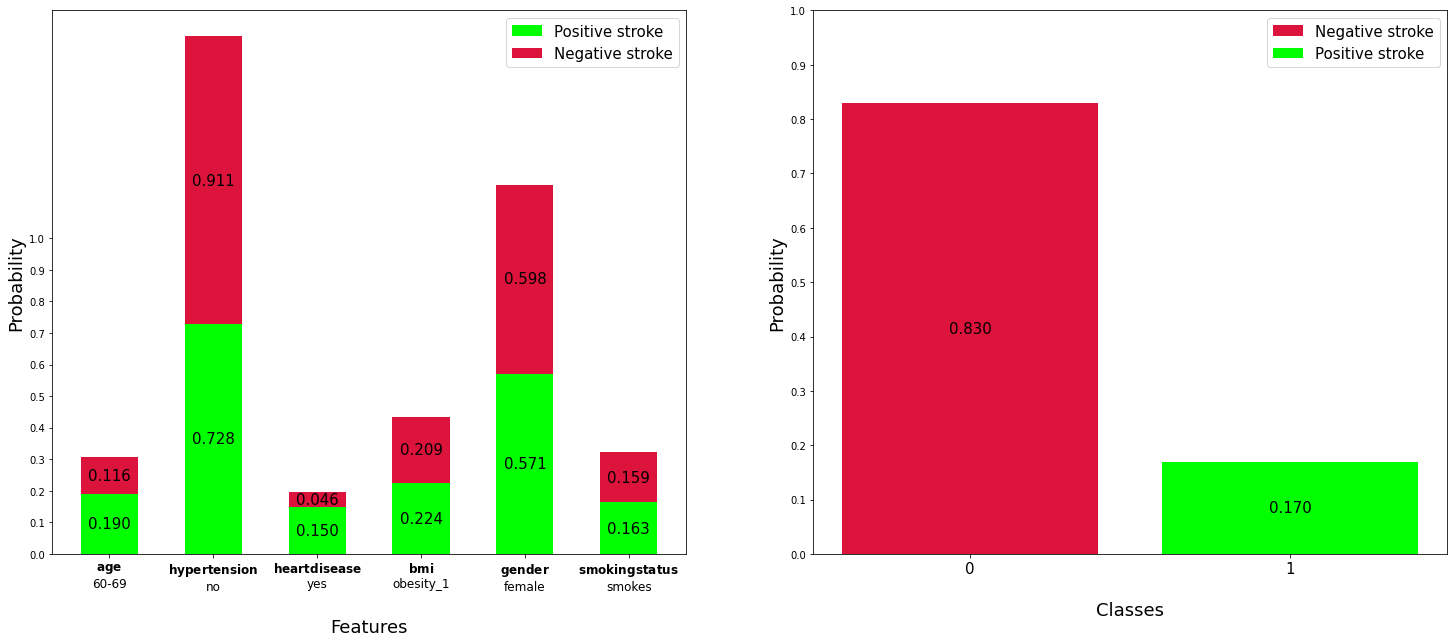

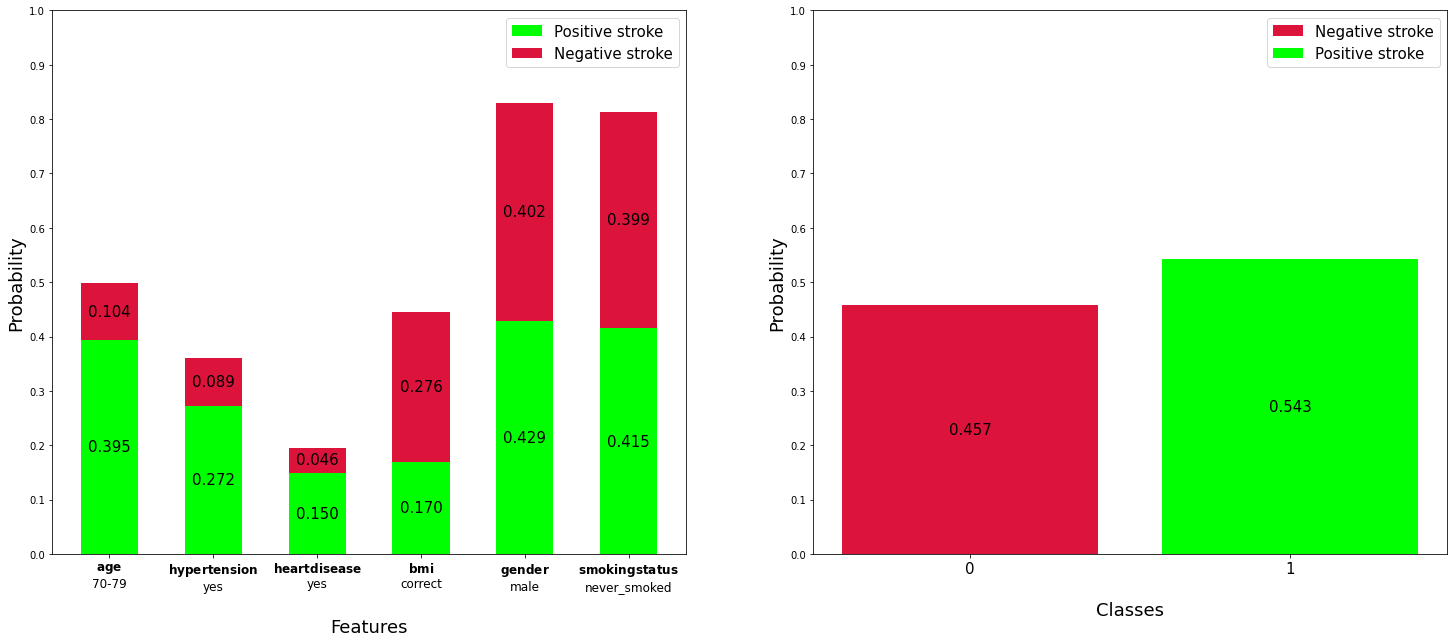

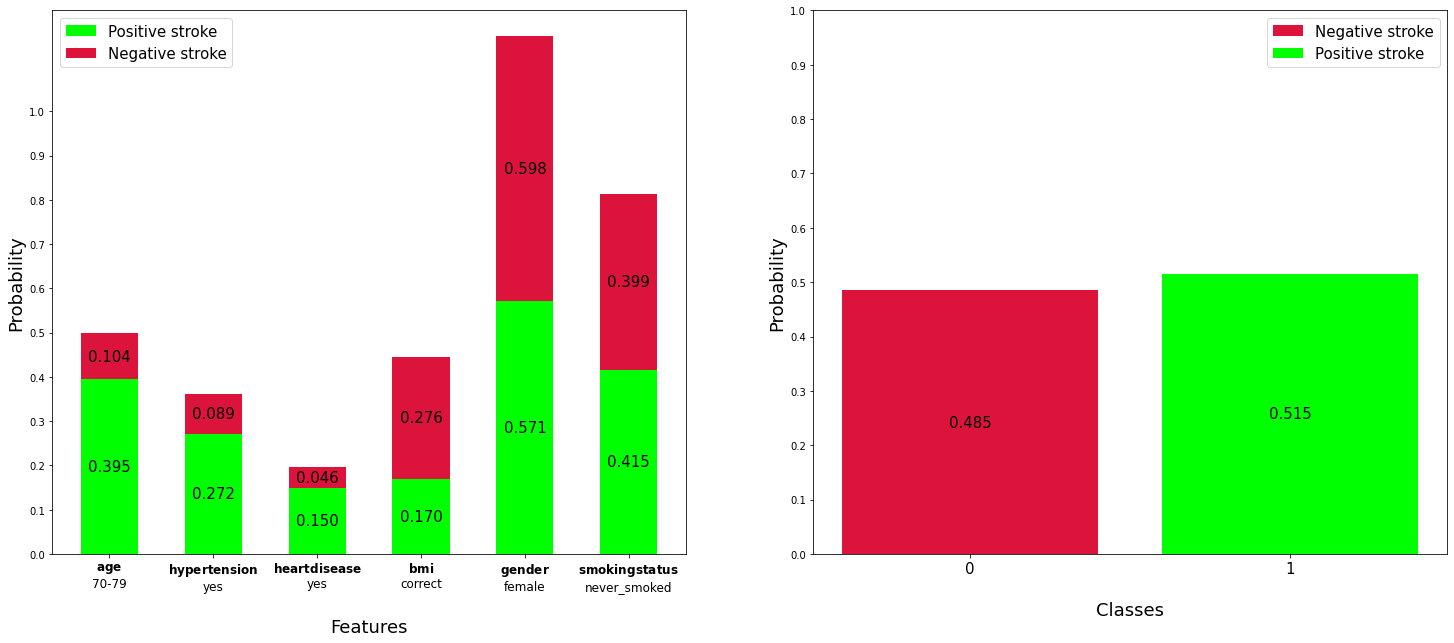

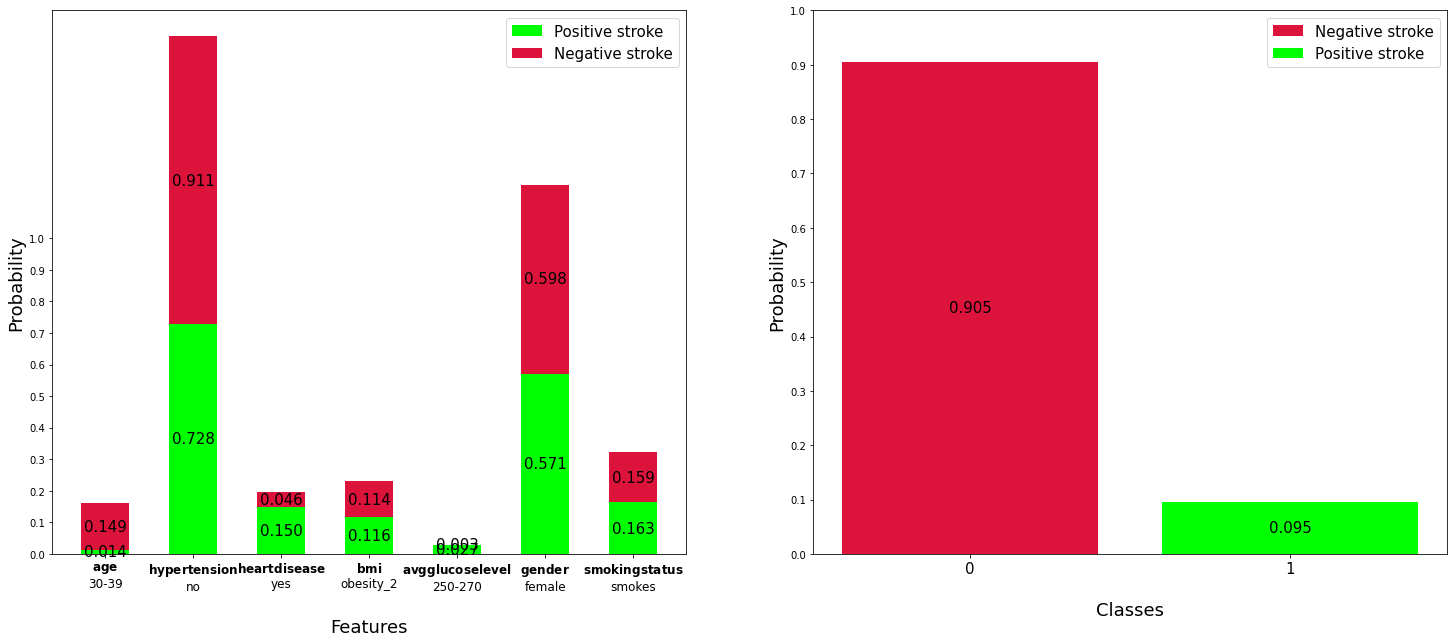

In [3]:
labels =  [[{'age': {'60-69'}},{'hypertension': {'no'}},{'heart_disease': {'yes'}},{'bmi': {'obesity_1'}},{'gender': {'female'}},{'smoking_status': {'smokes'}}],
           [{'age': {'70-79'}},{'hypertension': {'yes'}},{'heart_disease': {'yes'}},{'bmi': {'correct'}},{'gender': {'male'}},{'smoking_status': {'never_smoked'}}],
           [{'age': {'70-79'}},{'hypertension': {'yes'}},{'heart_disease': {'yes'}},{'bmi': {'correct'}},{'gender': {'female'}},{'smoking_status': {'never_smoked'}}],
           [{'age': {'30-39'}},{'hypertension': {'no'}},{'heart_disease': {'yes'}},{'bmi': {'obesity_2'}},{'avg_glucose_level': {'250-270'}},{'gender': {'female'}},{'smoking_status': {'smokes'}}]
          
          ]

for i in labels:
    naive_bayes = NaiveBayes(data_train, i, a_priori_prob)
    posteriori, labels = naive_bayes.count_bayes()
    plot_priori(labels,posteriori)